### **PINN eikonal solver using transfer learning for a smooth v(x,z) model**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd "/content/gdrive/My Drive/Colab Notebooks/Codes/PINN_isotropic_eikonal"

In [ ]:
!pip install sciann==0.4.6.2
!pip install tensorflow==2.2.0
!pip install keras==2.3.1 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel
from sciann.utils import *
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [5]:
np.random.seed(123)
tf.random.set_seed(123)

In [6]:
#Model specifications

v0 = 2.; # Velocity at the origin of the model
vergrad = 1.; # Vertical gradient
horgrad = 0.5; # Horizontal gradient

zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 2.; deltax = 0.02;


# Point-source location
sz = 0.3; sx = 1.4;

# Number of training points
num_tr_pts = 2000

In [7]:
# Creating grid, calculating refrence traveltimes, and prepare list of grid points for training (X_star)

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size


Z,X = np.meshgrid(z,x,indexing='ij')

# Preparing velocity model
vs = v0 + vergrad*sz + horgrad*sx # Velocity at the source location
velmodel = vs + vergrad*(Z-sz) + horgrad*(X-sx);

# Traveltime solution
if vergrad==0 and horgrad==0: 
  # For homogeneous velocity model
  T_data = np.sqrt((Z-sz)**2 + (X-sx)**2)/v0;
else: 
  # For velocity gradient model
  T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2))/np.sqrt(vergrad**2 + horgrad**2)


X_star = [Z.reshape(-1,1), X.reshape(-1,1)] # Grid points for prediction 

selected_pts = np.random.choice(np.arange(Z.size),num_tr_pts,replace=False)
Zf = Z.reshape(-1,1)[selected_pts]
Zf = np.append(Zf,sz)
Xf = X.reshape(-1,1)[selected_pts]
Xf = np.append(Xf,sx)


X_starf = [Zf.reshape(-1,1), Xf.reshape(-1,1)] # Grid points for training


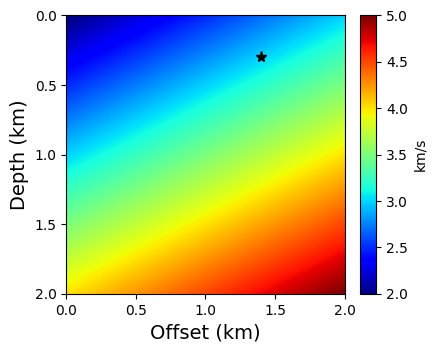

In [8]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofz_transfer/velmodel.pdf", format='pdf', bbox_inches="tight")

In [9]:
# Analytical solution for the known traveltime part
vel = velmodel[int(round(sz/deltaz)),int(round(sx/deltax))] # Velocity at the source location

T0 = np.sqrt((Z-sz)**2 + (X-sx)**2)/vel; 

px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)

In [10]:
# Find source location id in X_star

TOLX = 1e-6
TOLZ = 1e-6

sids,_ = np.where(np.logical_and(np.abs(X_starf[0]-sz)<TOLZ , np.abs(X_starf[1]-sx)<TOLX))

print(sids)
print(sids.shape)
print(X_starf[0][sids,0])
print(X_starf[1][sids,0])

[2000]
(1,)
[0.3]
[1.4]


In [11]:
# Preparing the Sciann model object

K.clear_session() 

layers = [20]*10

# Appending source values
velmodelf = velmodel.reshape(-1,1)[selected_pts]; velmodelf = np.append(velmodelf,vs)
px0f = px0.reshape(-1,1)[selected_pts]; px0f = np.append(px0f,0.)
pz0f = pz0.reshape(-1,1)[selected_pts]; pz0f = np.append(pz0f,0.)
T0f = T0.reshape(-1,1)[selected_pts]; T0f = np.append(T0f,0.)

xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
vt = Variable("vt",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')

tau = Functional("tau", [zt, xt], layers, 'atan')

# Loss function based on the factored isotropic eikonal equation
L = (T0t*diff(tau, xt) + tau*px0t)**2 + (T0t*diff(tau, zt) + tau*pz0t)**2 - 1.0/vt**2

targets = [tau, L, (1-sign(tau*T0t))*abs(tau*T0t)]
target_vals = [(sids, np.ones(sids.shape).reshape(-1,1)), 'zeros', 'zeros']

model = SciModel(
    [zt, xt, vt, pz0t, px0t, T0t], 
    targets,
    load_weights_from='models/vofz_model-end.hdf5'
)

In [ ]:
#Model training

start_time = time.time()
hist = model.train(
       X_starf + [velmodelf,pz0f,px0f,T0f],
       target_vals,
       batch_size = X_starf[0].size,
       epochs = 5000,
       learning_rate = 0.0005,
       verbose=0
       )
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

In [13]:
# Loading loss history and compute time for the pre-trained model

loss = np.load('models/loss_vofz.npy')
time_vofz = np.load('models/time_vofz.npy')

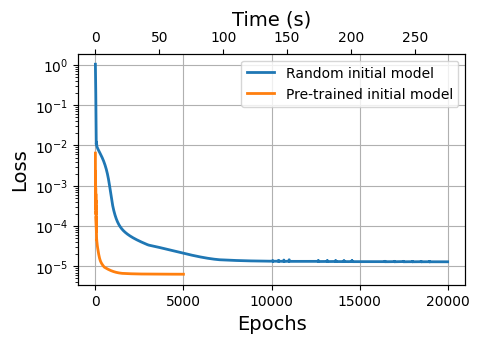

In [14]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(loss,LineWidth=2,label='Random initial model')
ax.semilogy(hist.history['loss'],LineWidth=2,label='Pre-trained initial model')


ax.set_xlabel('Epochs',fontsize=14)

plt.xticks(fontsize=10)
ax.xaxis.set_major_locator(plt.MultipleLocator(5000))

ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=10);
plt.grid()
plt.legend()

ax2 = ax.twiny()
ax2.set_xlabel("x-transformed")
ax2.set_xlim(-time_vofz*.05, time_vofz*1.05)
ax2.set_xlabel('Time (s)',fontsize=14)

plt.savefig("./figs/vofz_transfer/loss.pdf", format='pdf', bbox_inches="tight")

In [15]:
# Predicting traveltime solution from the trained model

L_pred = L.eval(model, X_star + [velmodel,pz0,px0,T0])
tau_pred = tau.eval(model, X_star + [velmodel,pz0,px0,T0])
tau_pred = tau_pred.reshape(Z.shape)

T_pred = tau_pred*T0

print('Time at source: %.4f'%(tau_pred[int(round(sz/deltaz)),int(round(sx/deltax))]))

Time at source: 1.0000


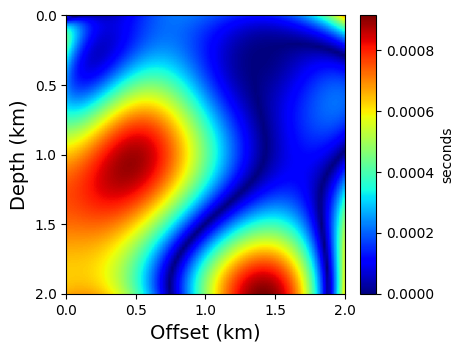

In [16]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofz_transfer/pinnerror.pdf", format='pdf', bbox_inches="tight")

In [17]:
# Loading fast marching solutions

# First order FMM solution
time_fmm1="data/fmm_or1_vofz_s(1.4,.3).txt"

T_fmm1 = pd.read_csv(time_fmm1, index_col=None, header=None)
T_fmm1 = np.reshape(np.array(T_fmm1), (nx, nz)).T

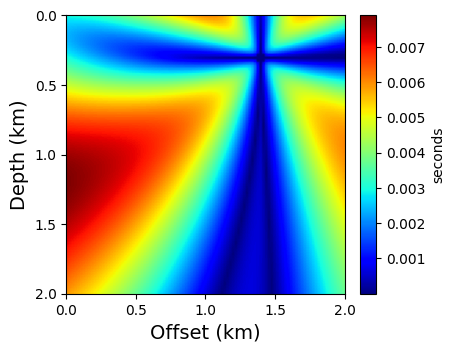

In [18]:
# Plot the first order FMM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fmm1-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)

cbar.ax.tick_params(labelsize=10)

plt.savefig("./figs/vofz_transfer/fmm1error.pdf", format='pdf', bbox_inches="tight")

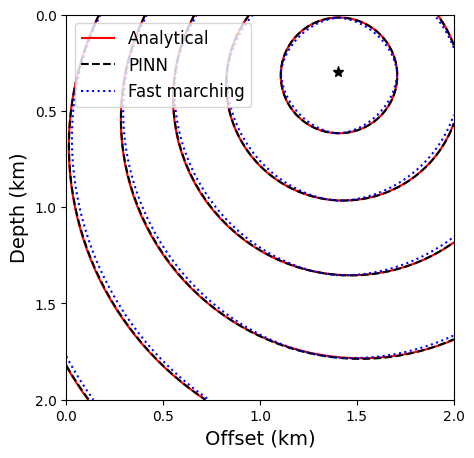

In [19]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fmm1, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast marching'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("./figs/vofz_transfer/contours.pdf", format='pdf', bbox_inches="tight")


In [ ]:
print(np.linalg.norm(T_pred-T_data)/np.linalg.norm(T_data))
print(np.linalg.norm(T_pred-T_data))

In [21]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b1896277-0760-d228-c7e3-e9e6f9e69c24)
